In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

In [2]:
files = [f for f in listdir("csv") if isfile(join("csv", f))]
#files

<ipython-input-3-acc2403156ed>:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


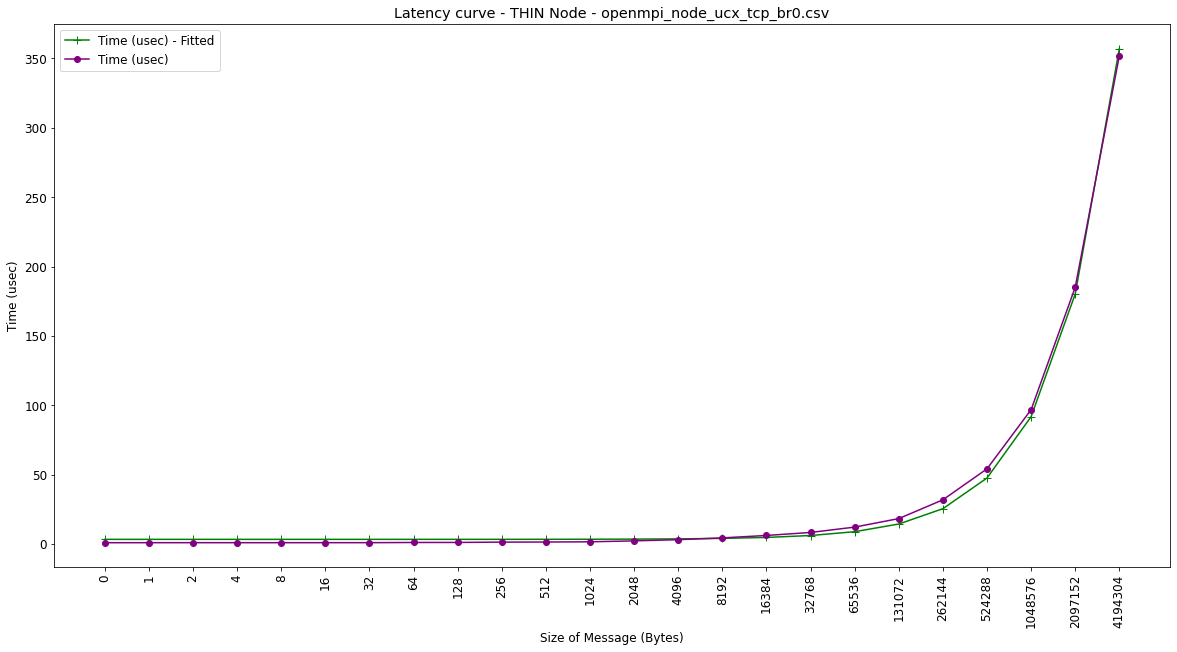

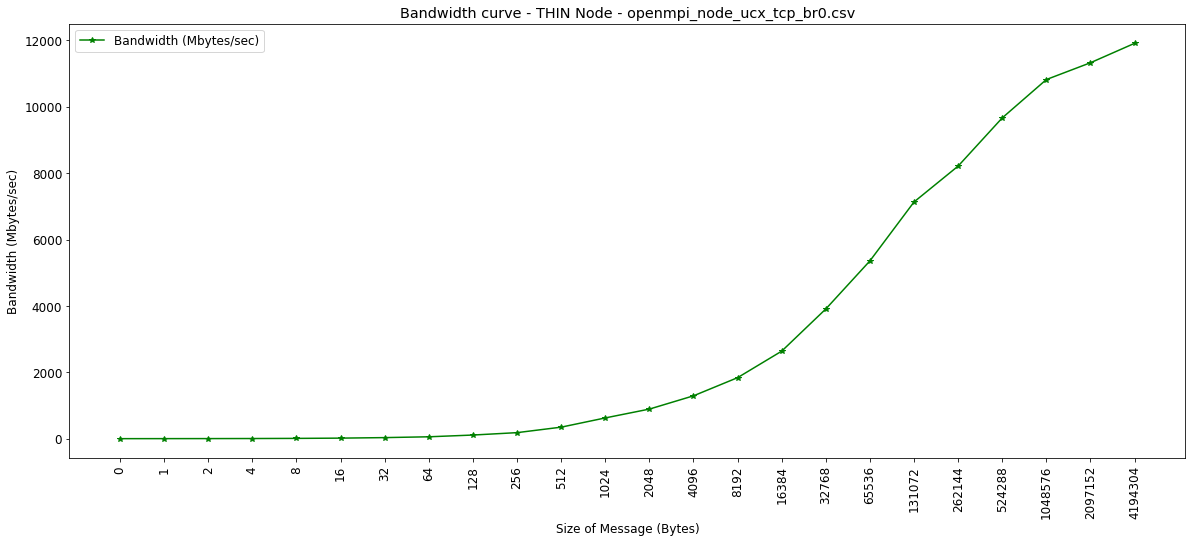

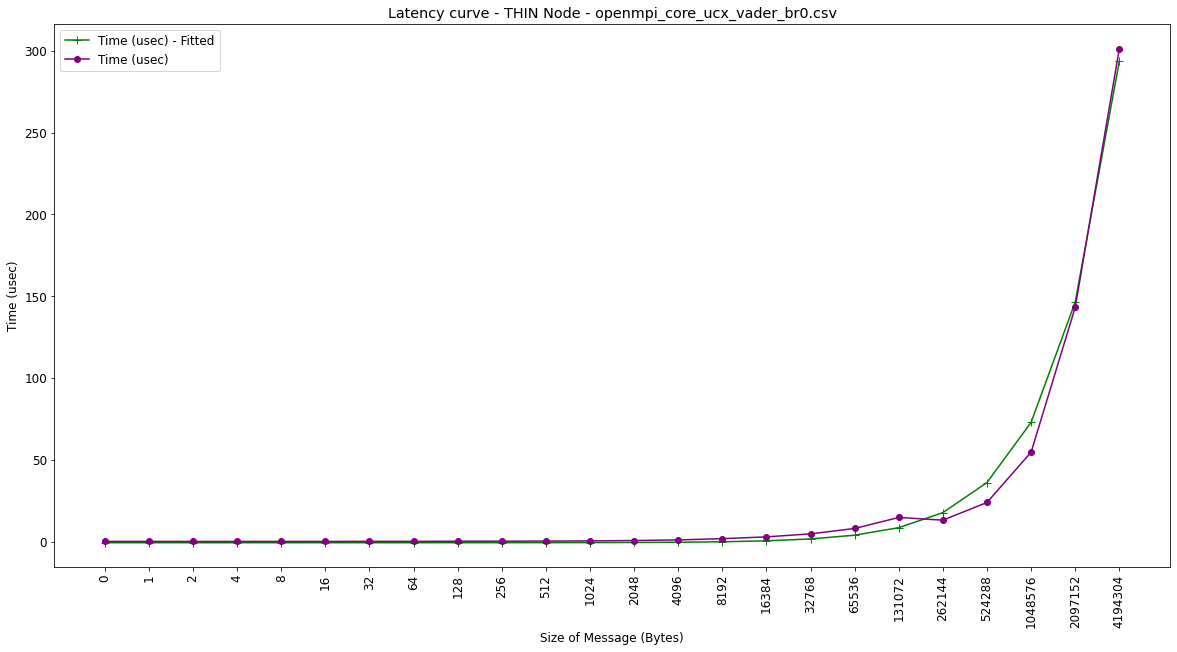

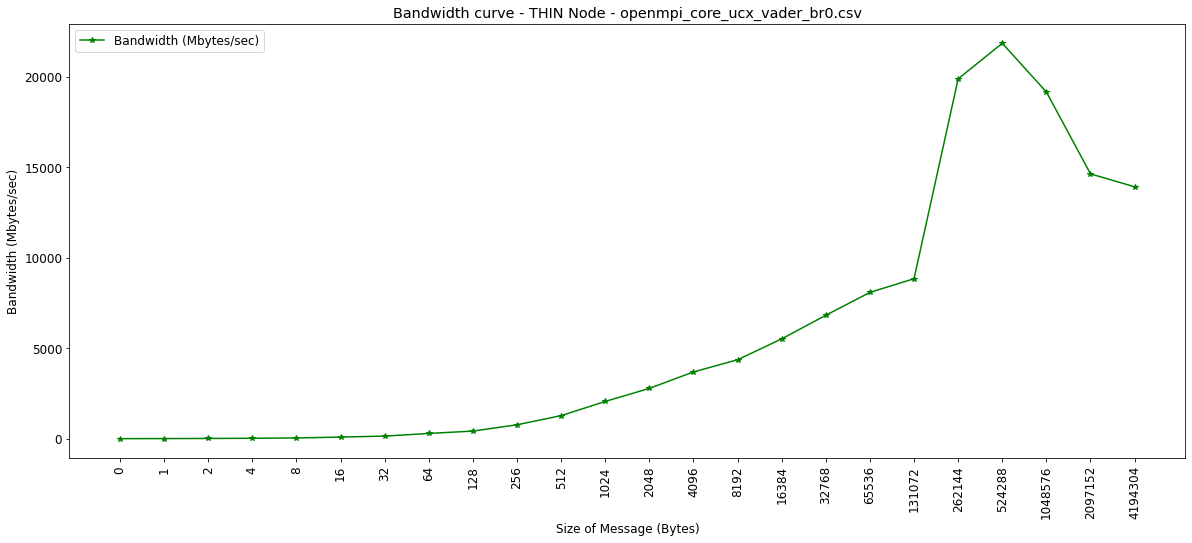

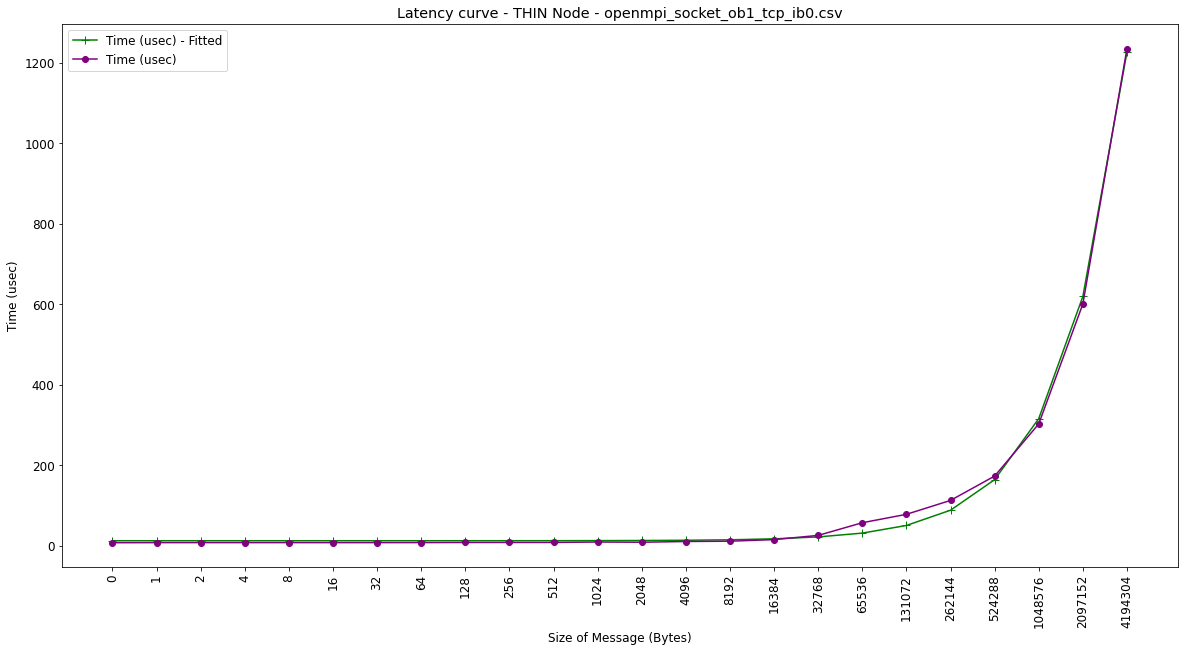

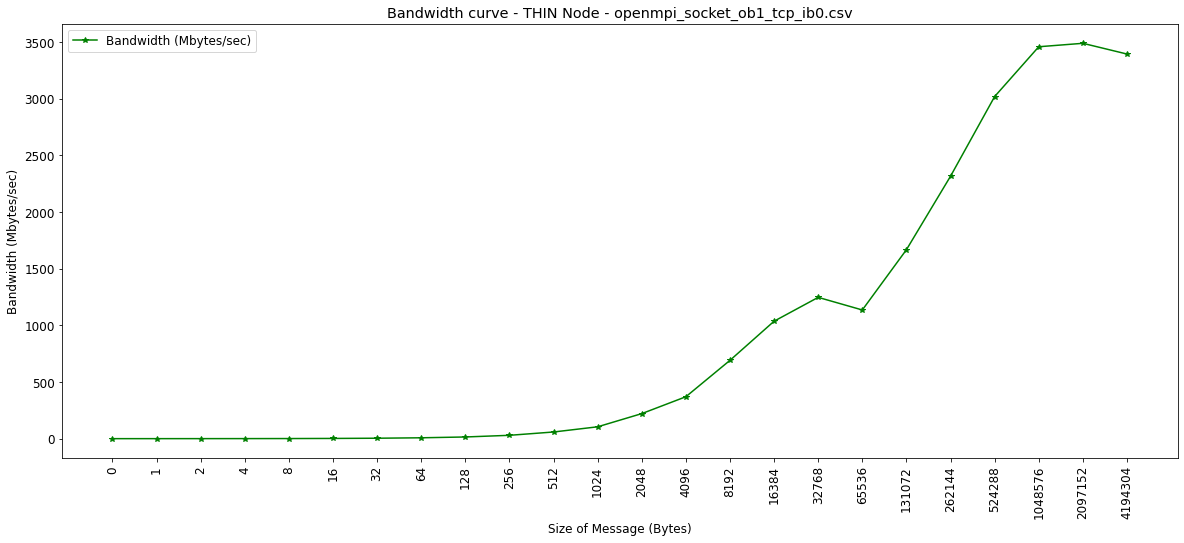

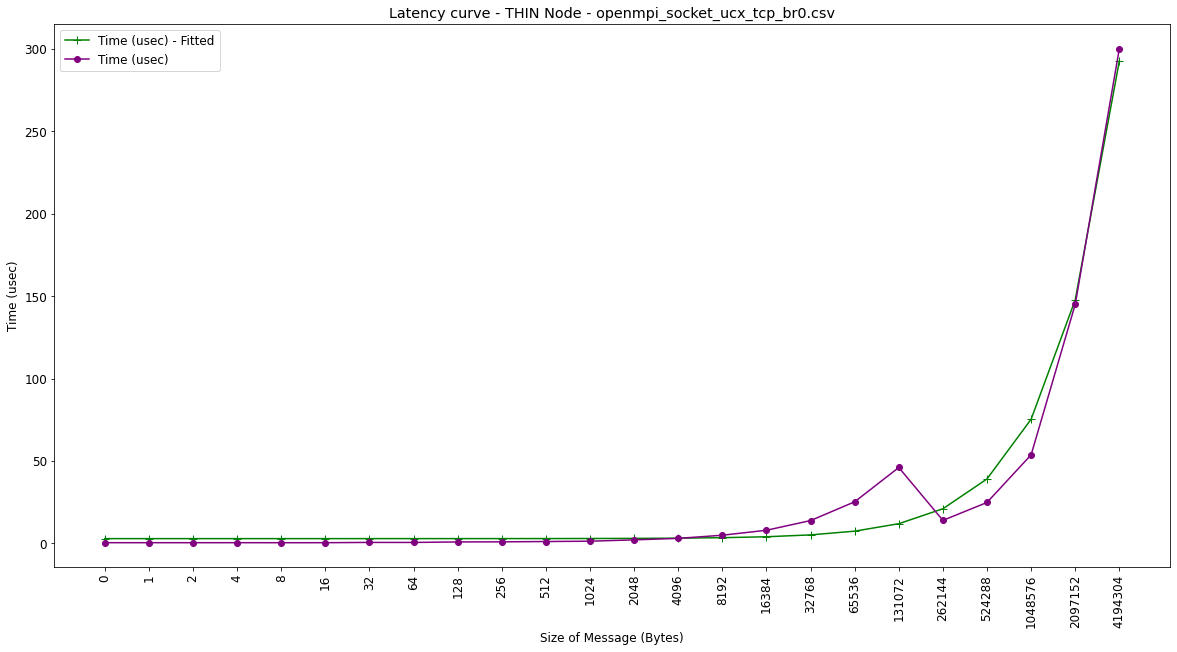

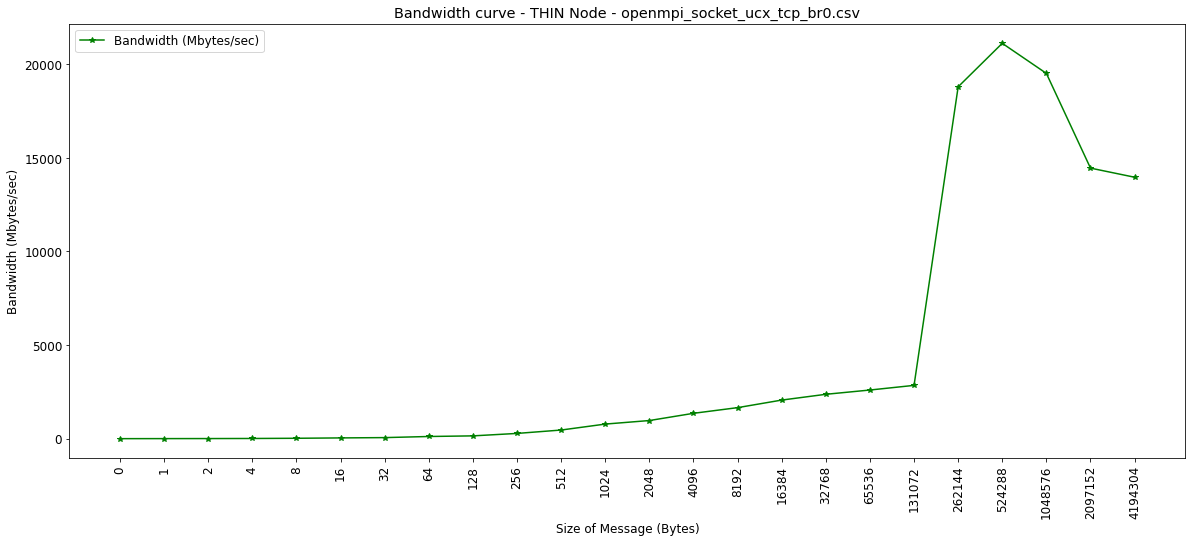

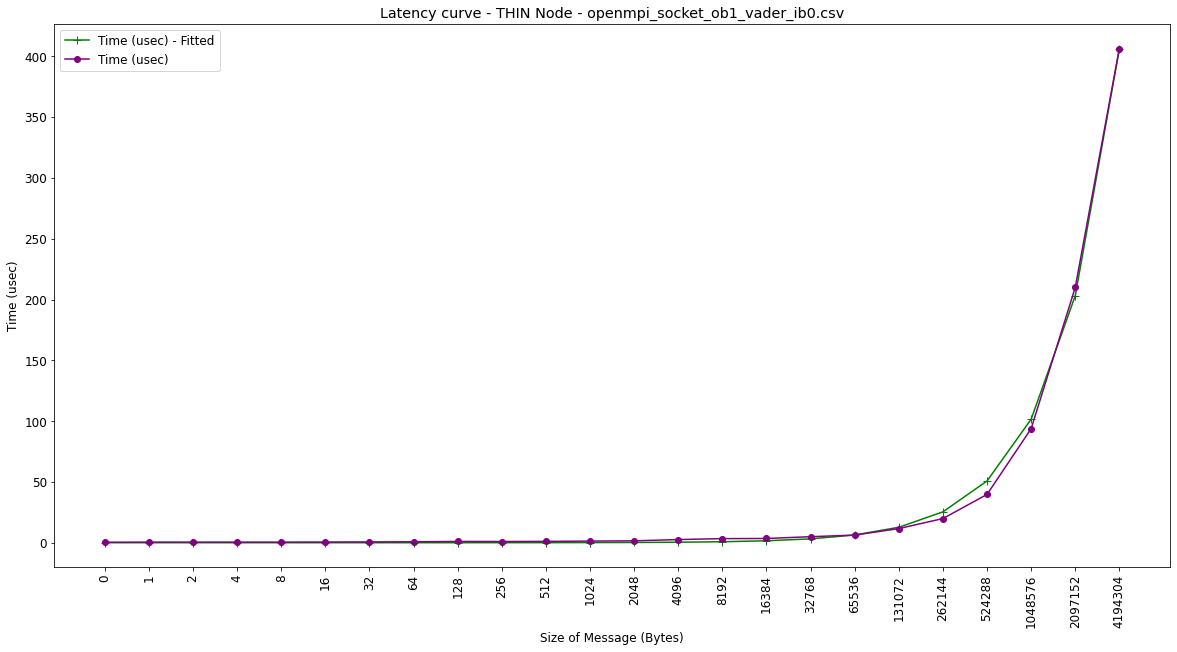

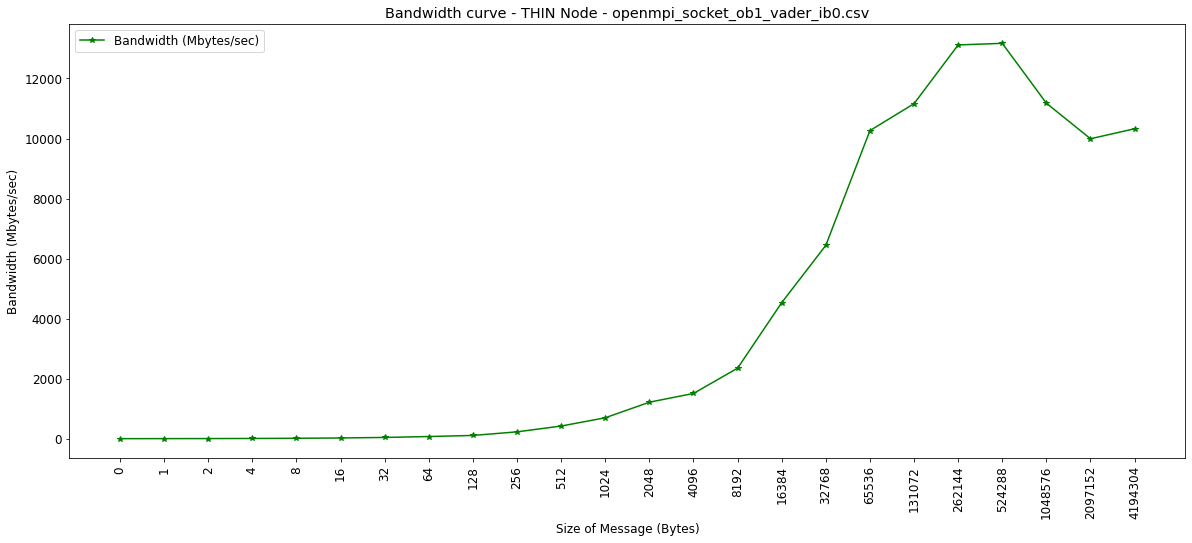

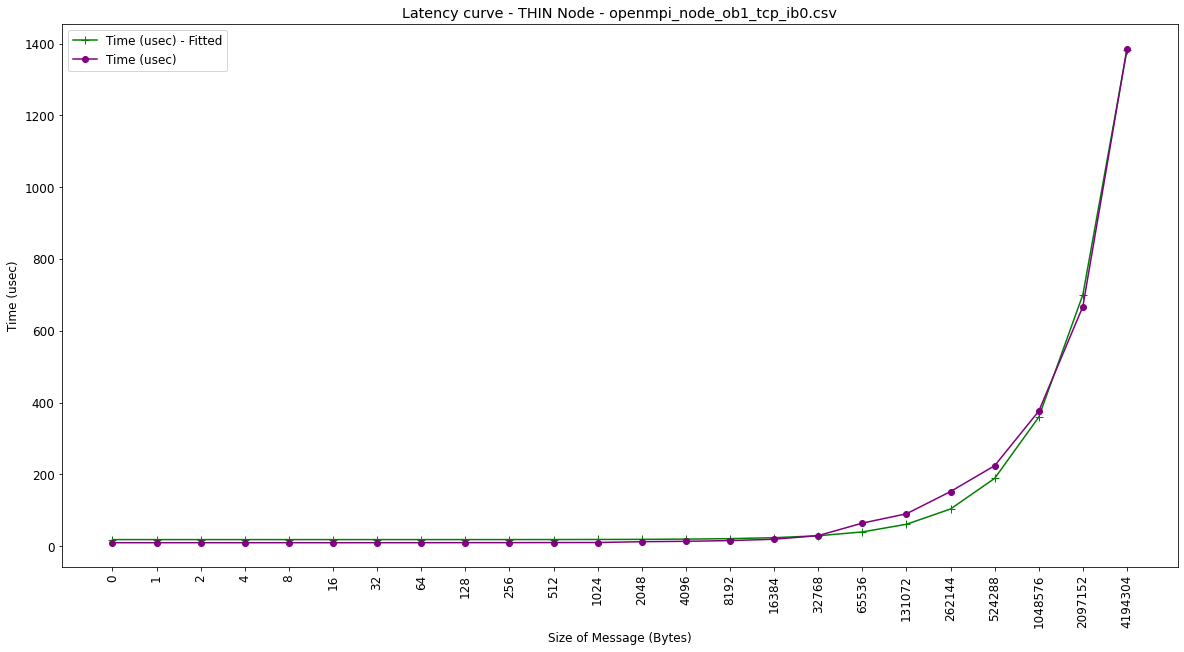

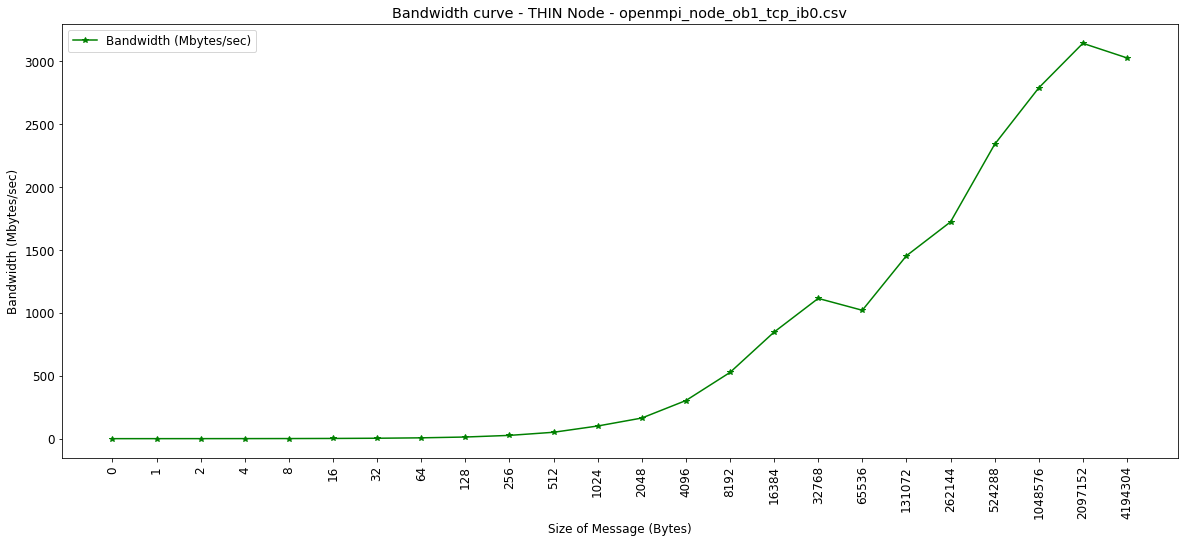

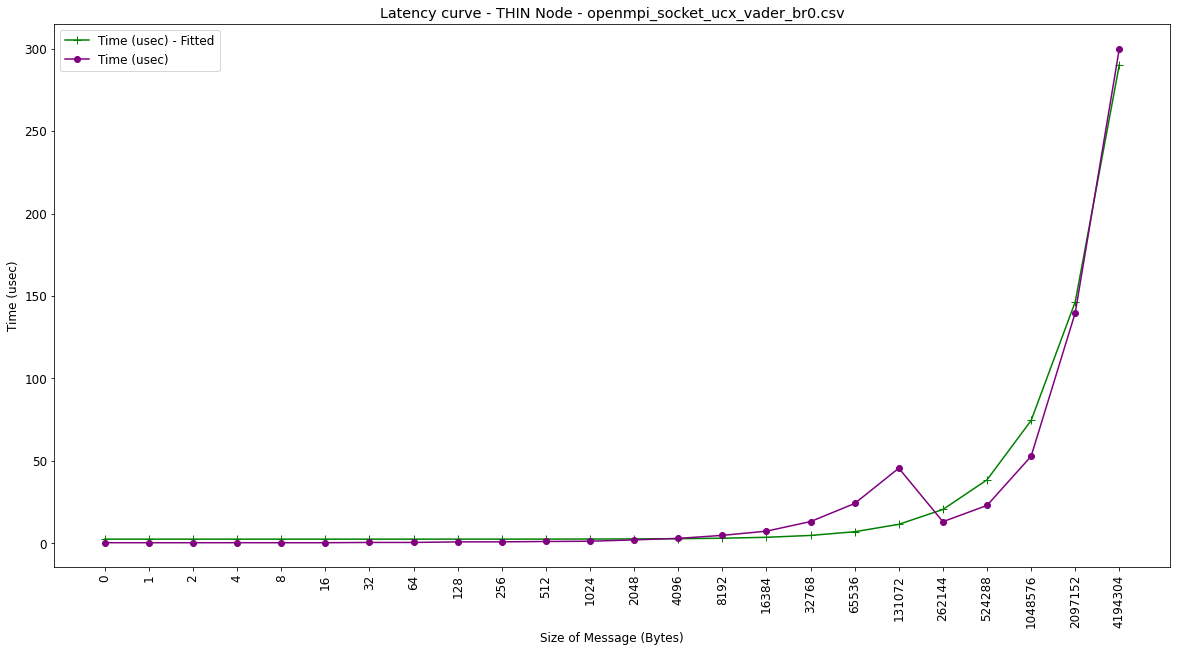

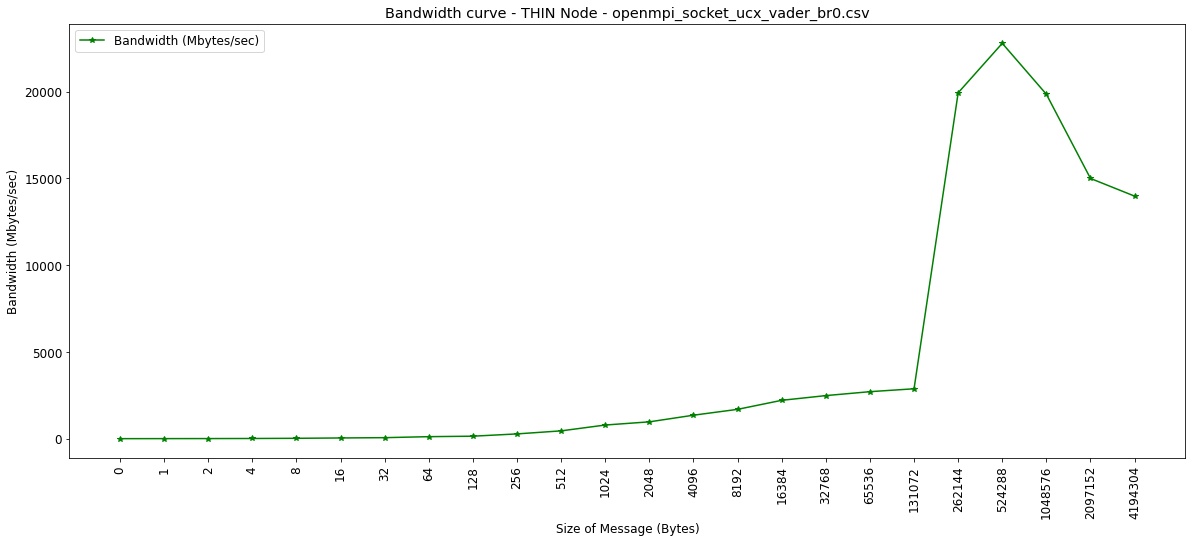

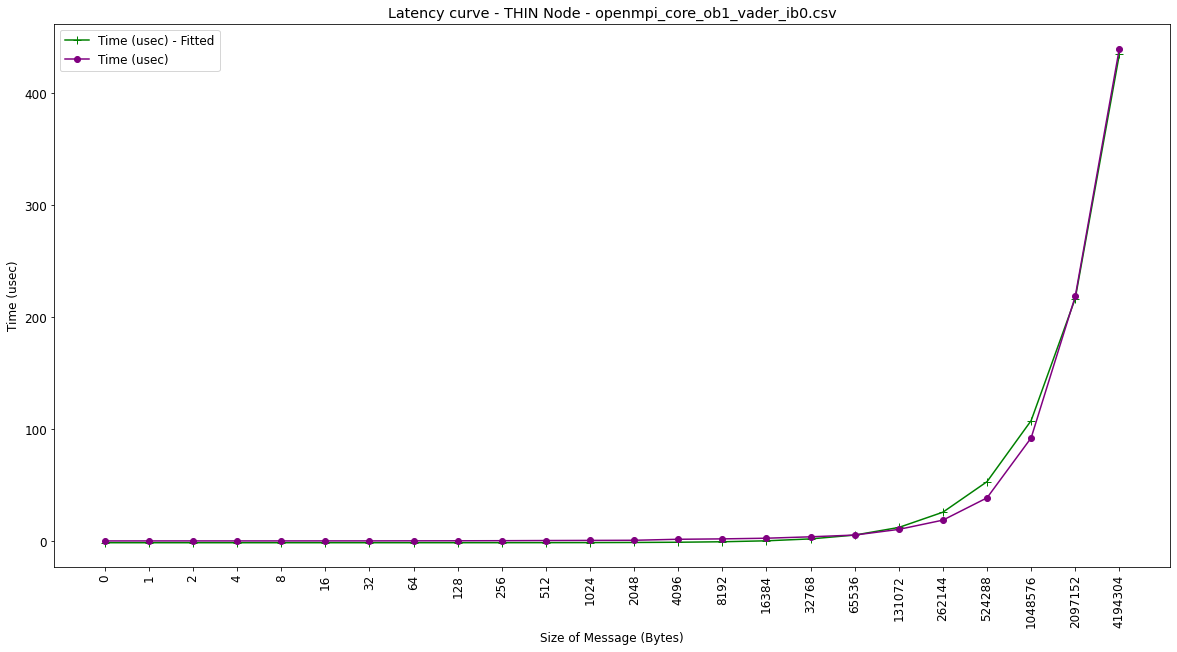

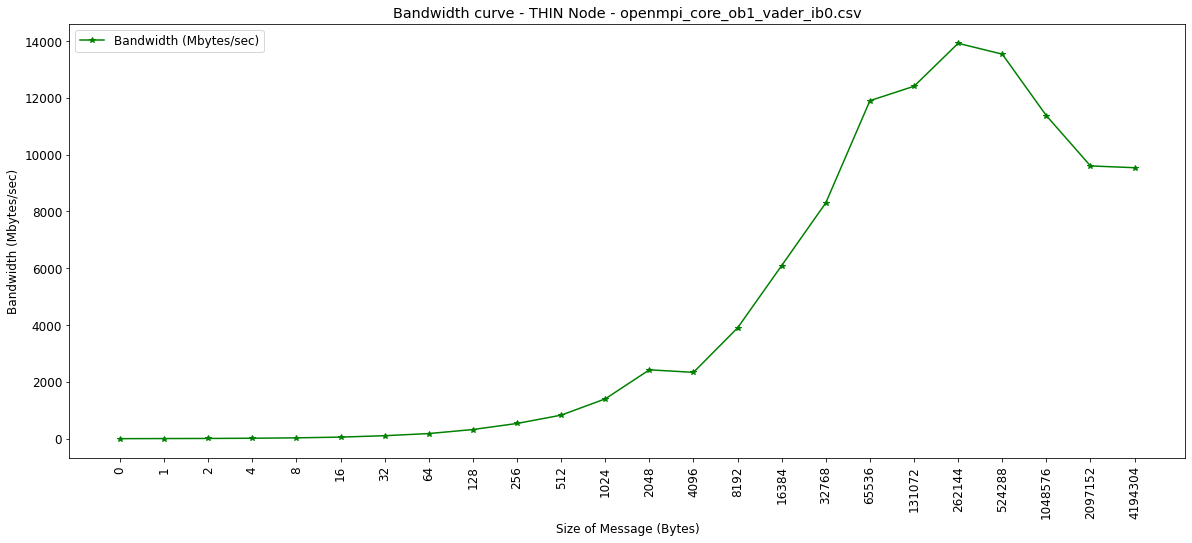

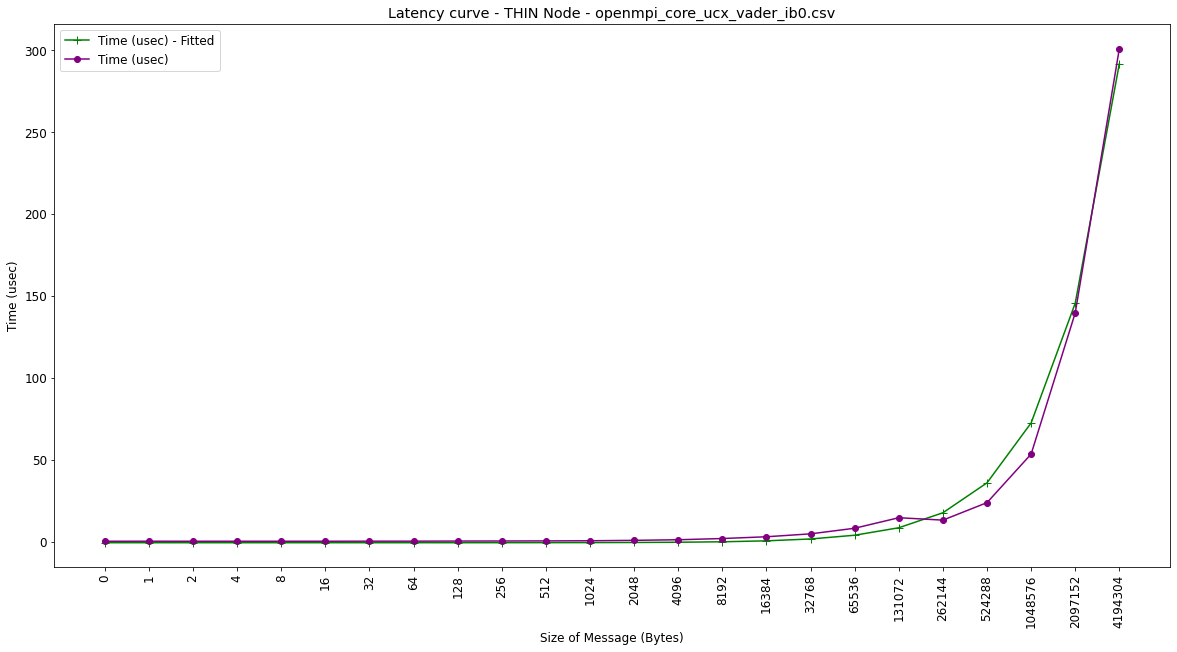

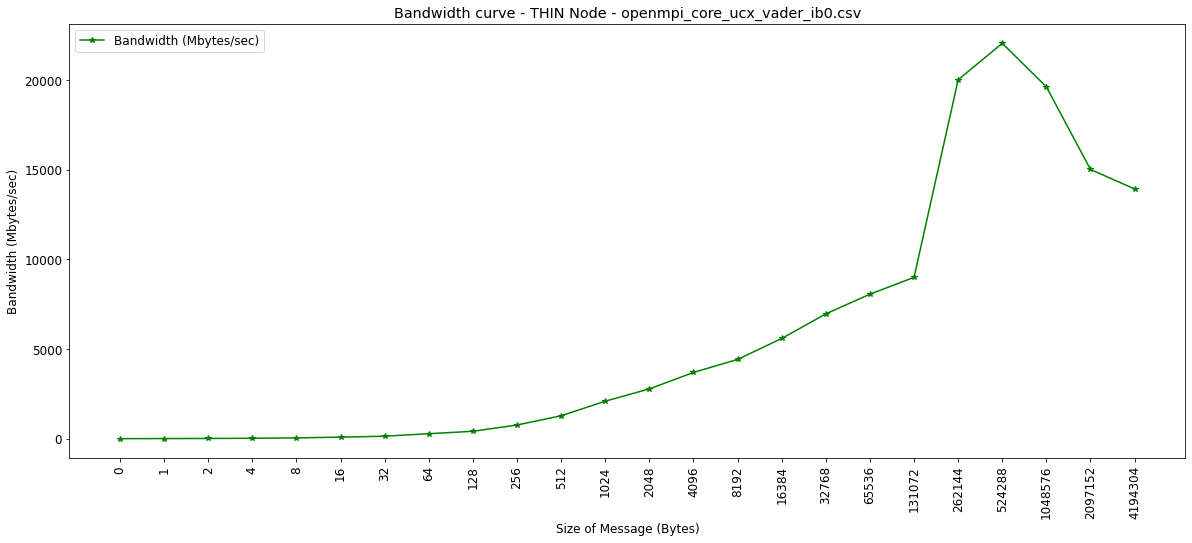

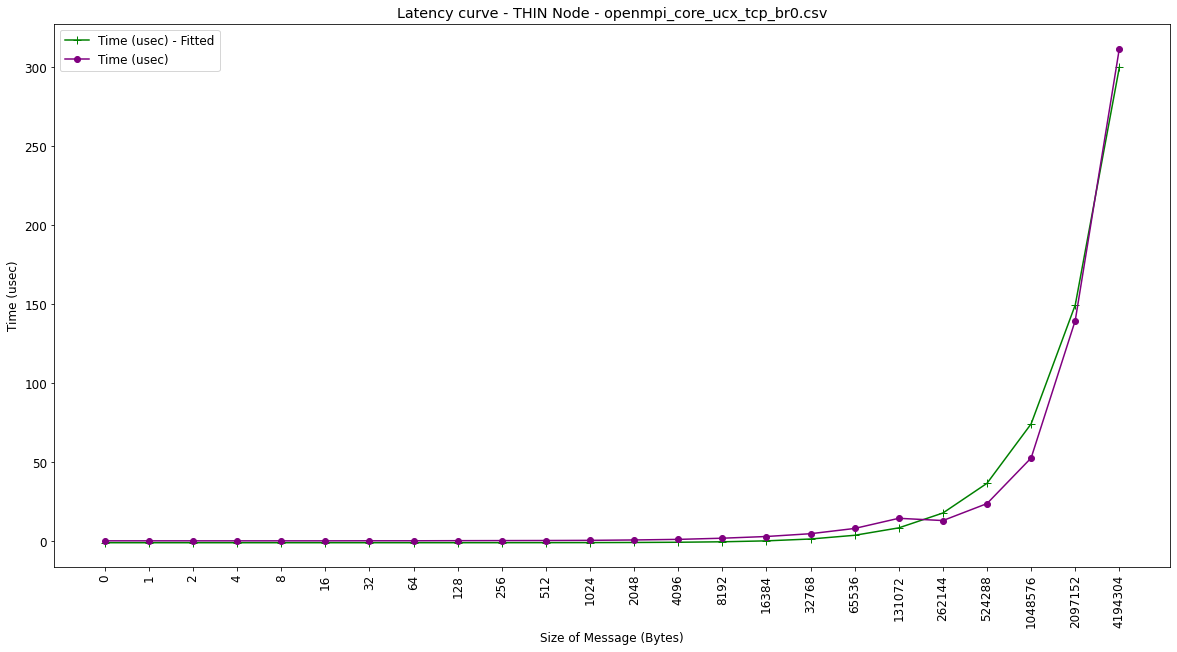

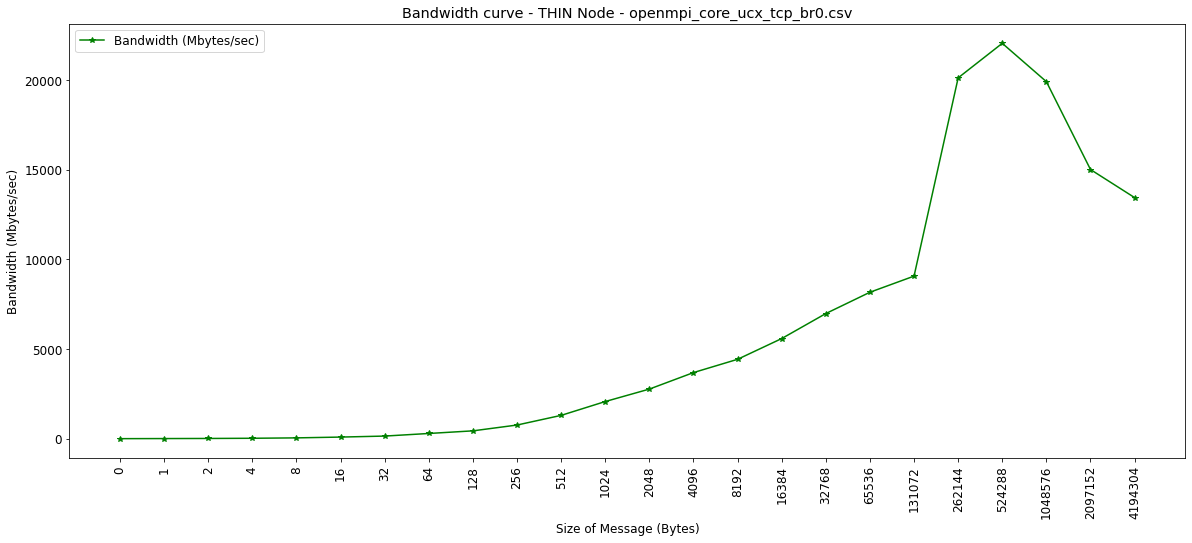

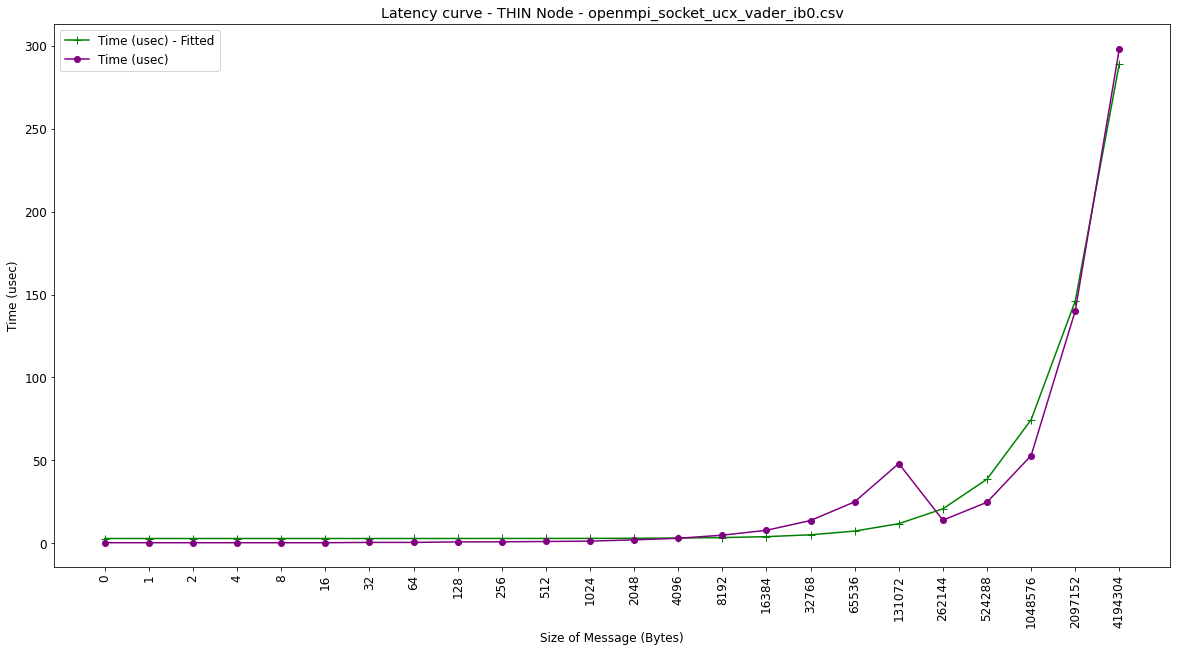

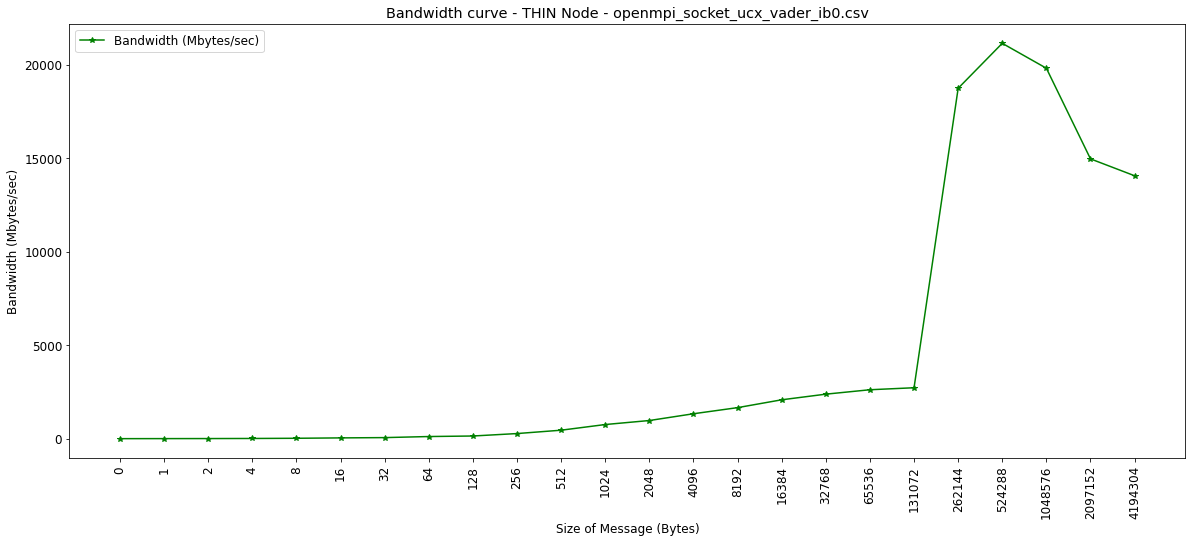

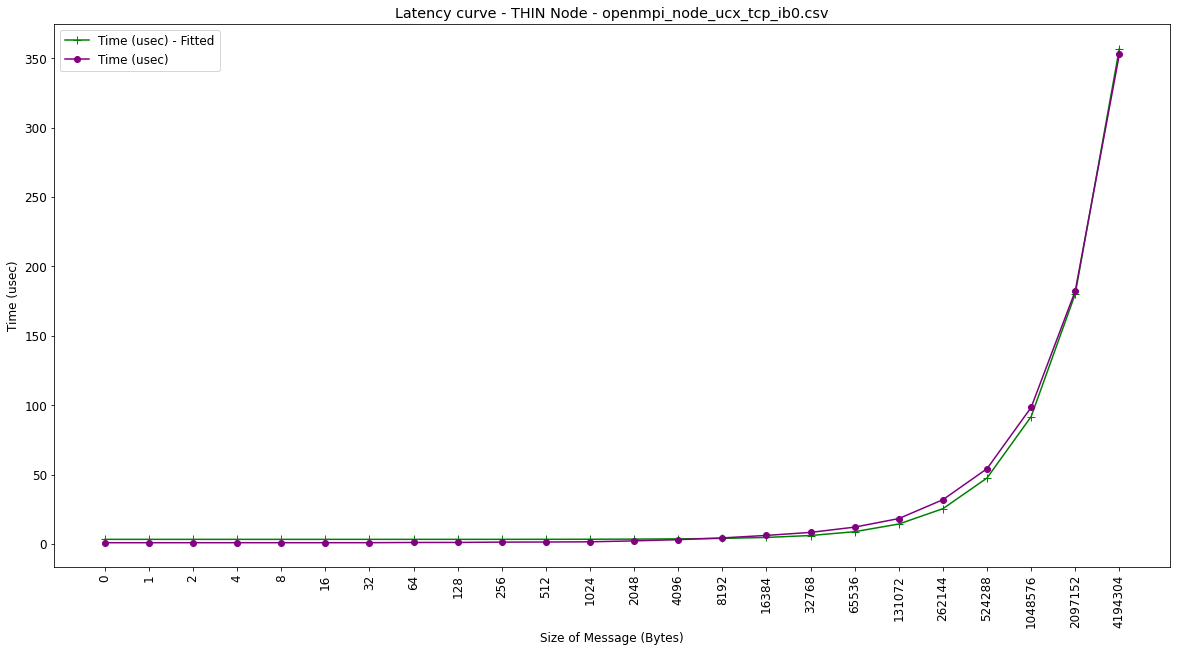

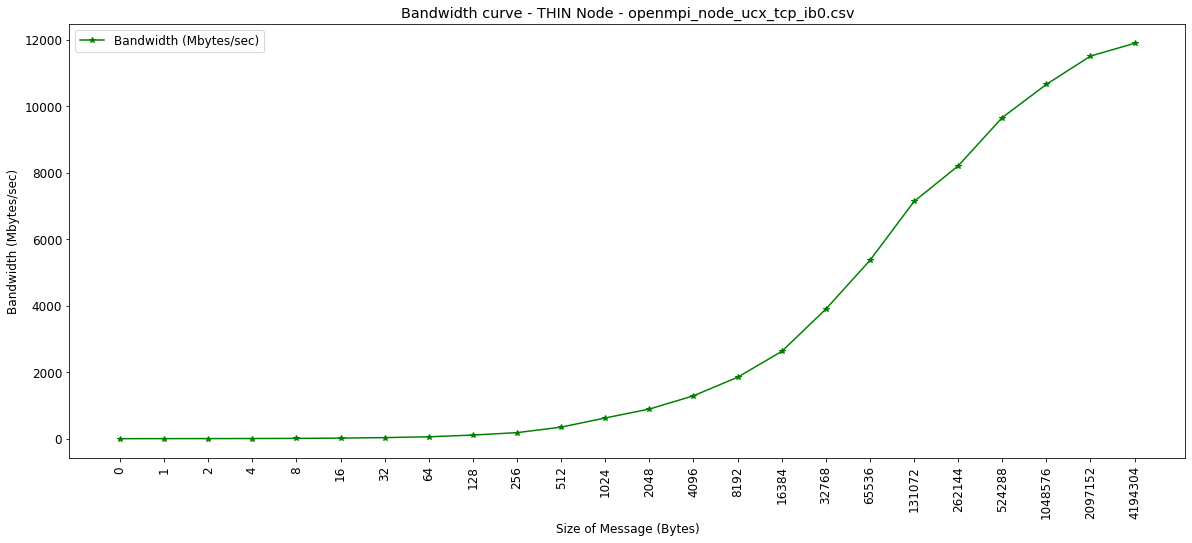

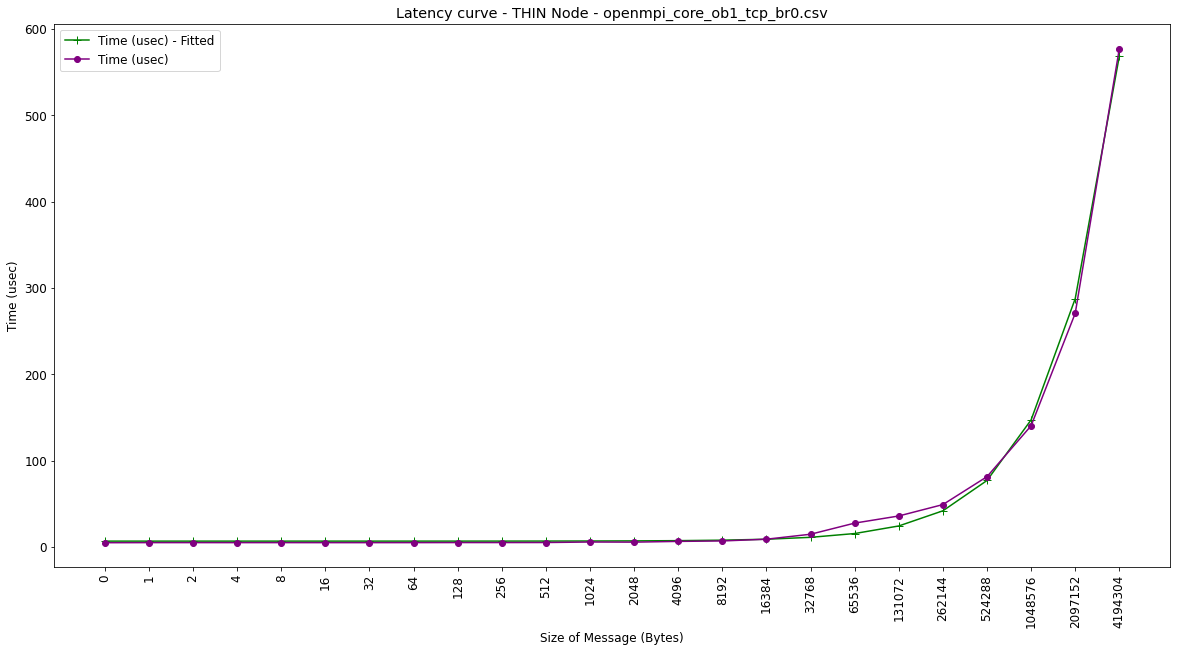

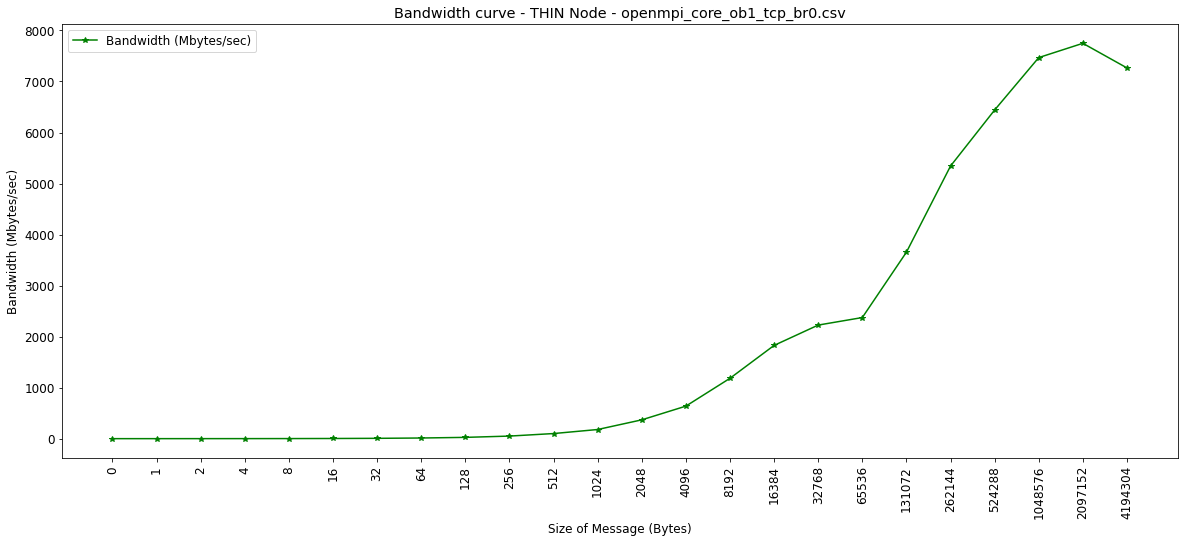

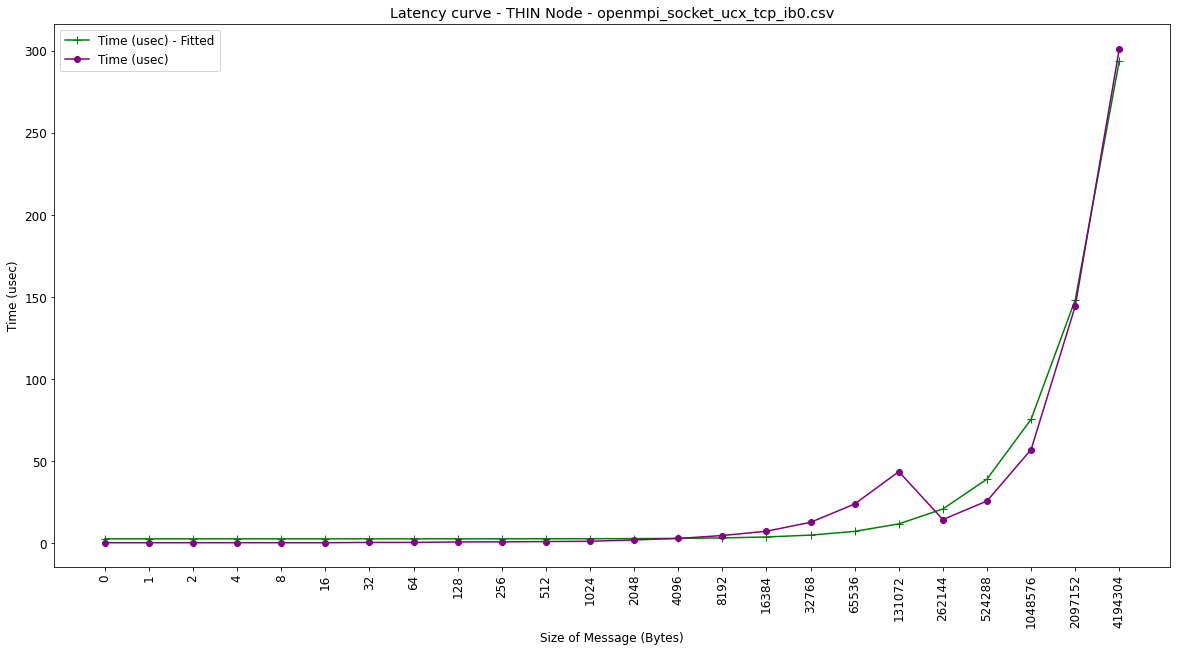

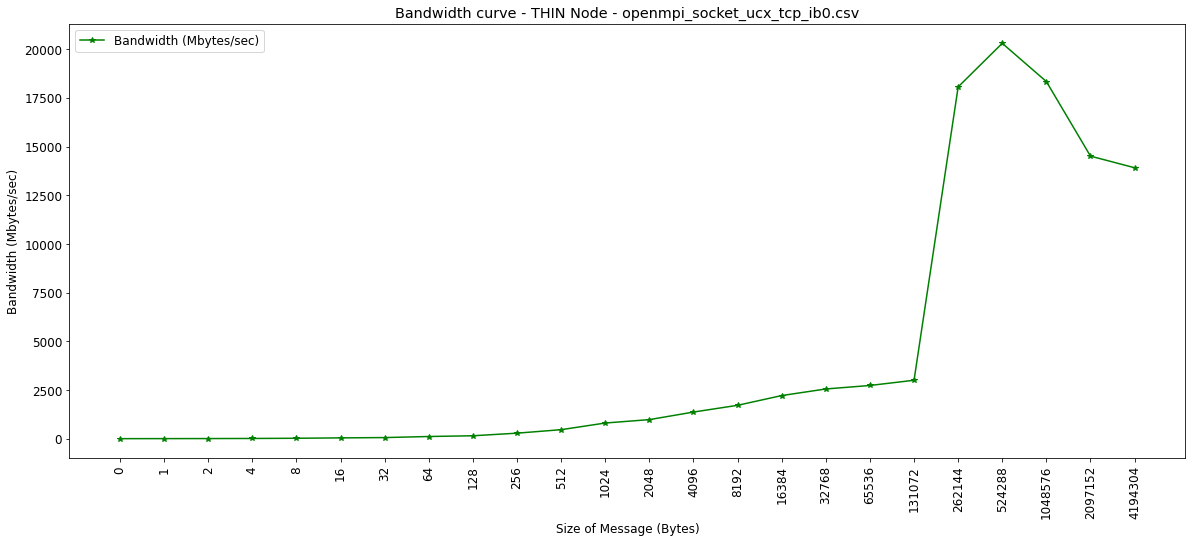

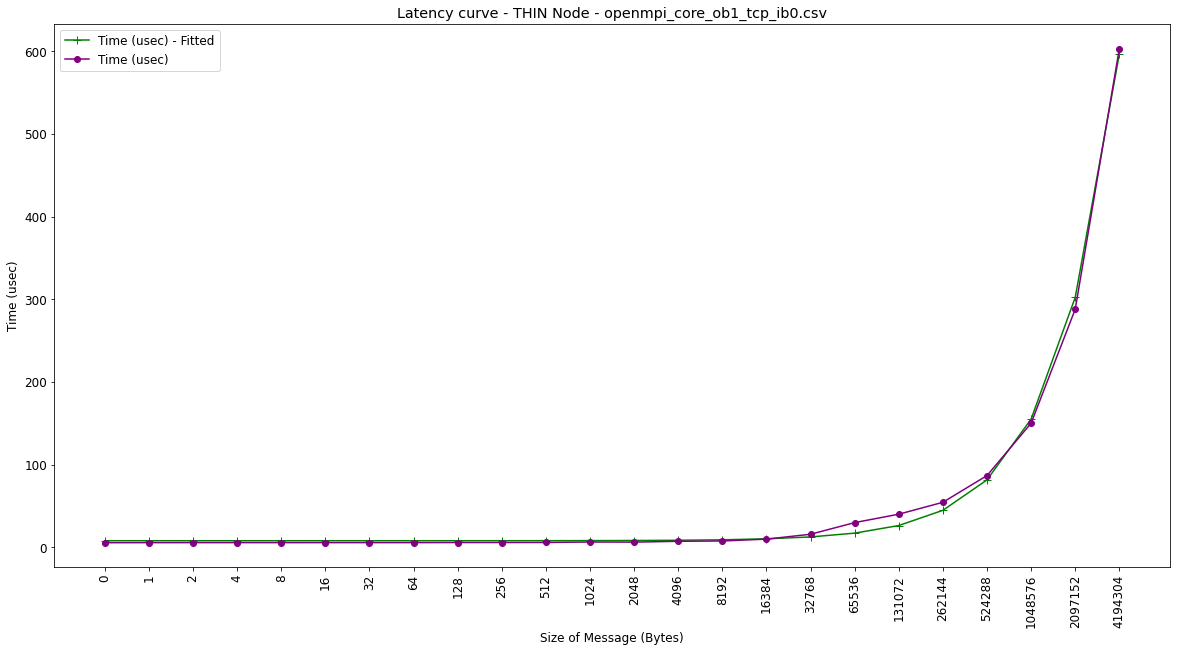

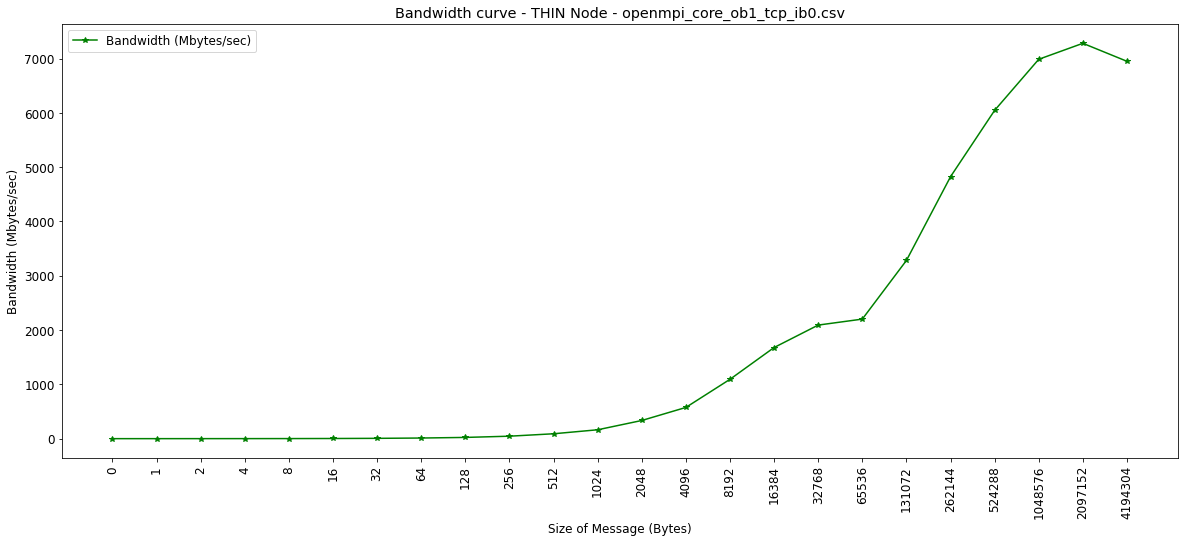

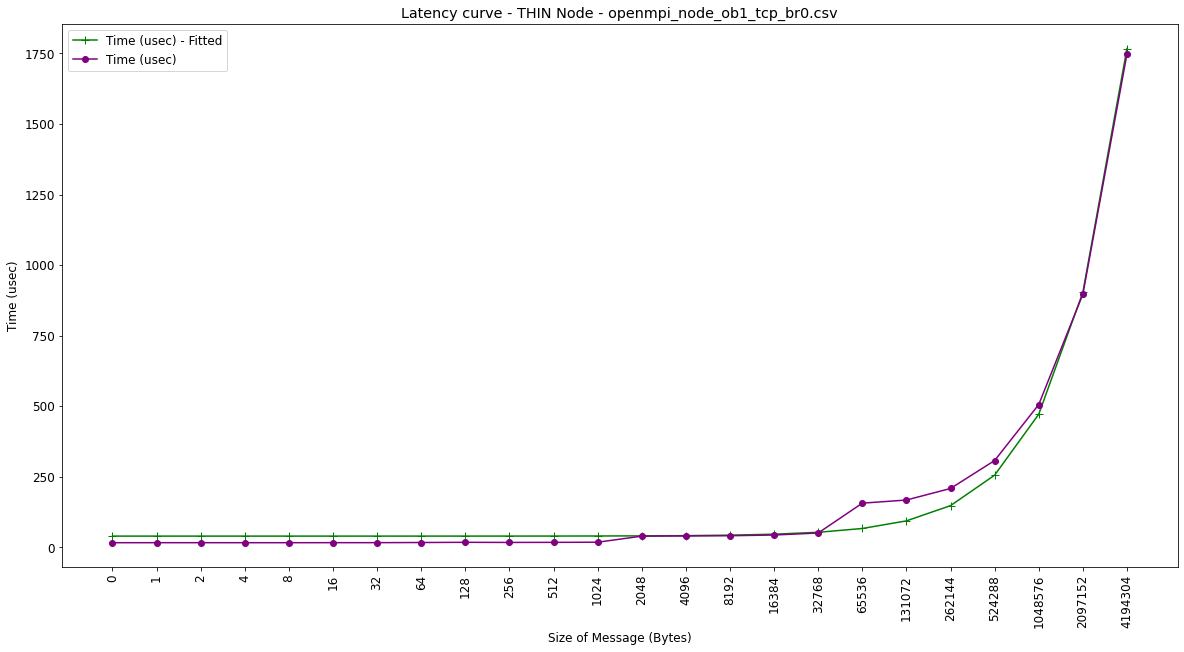

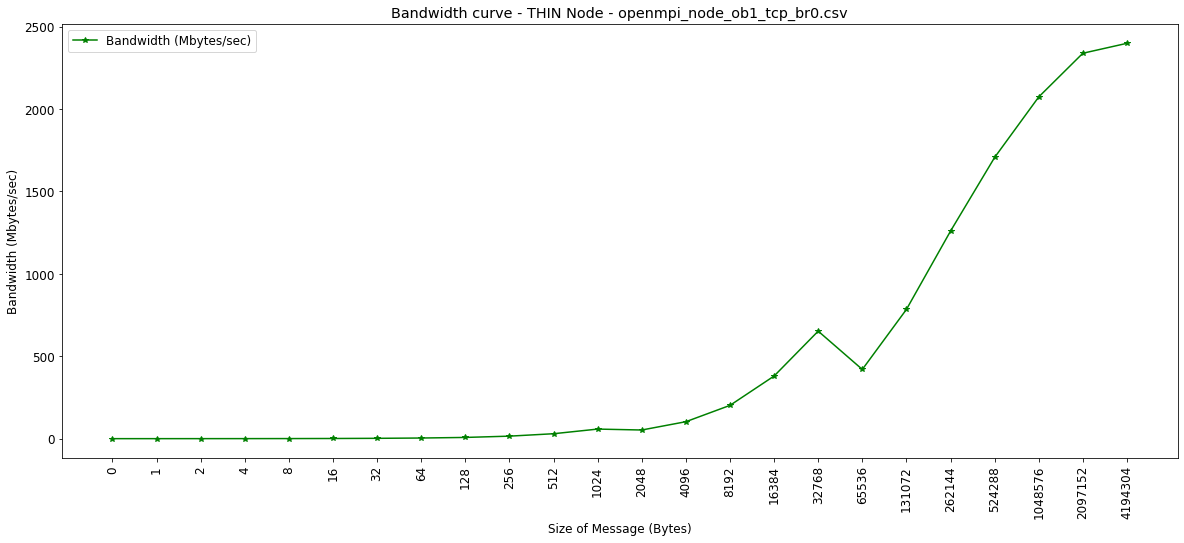

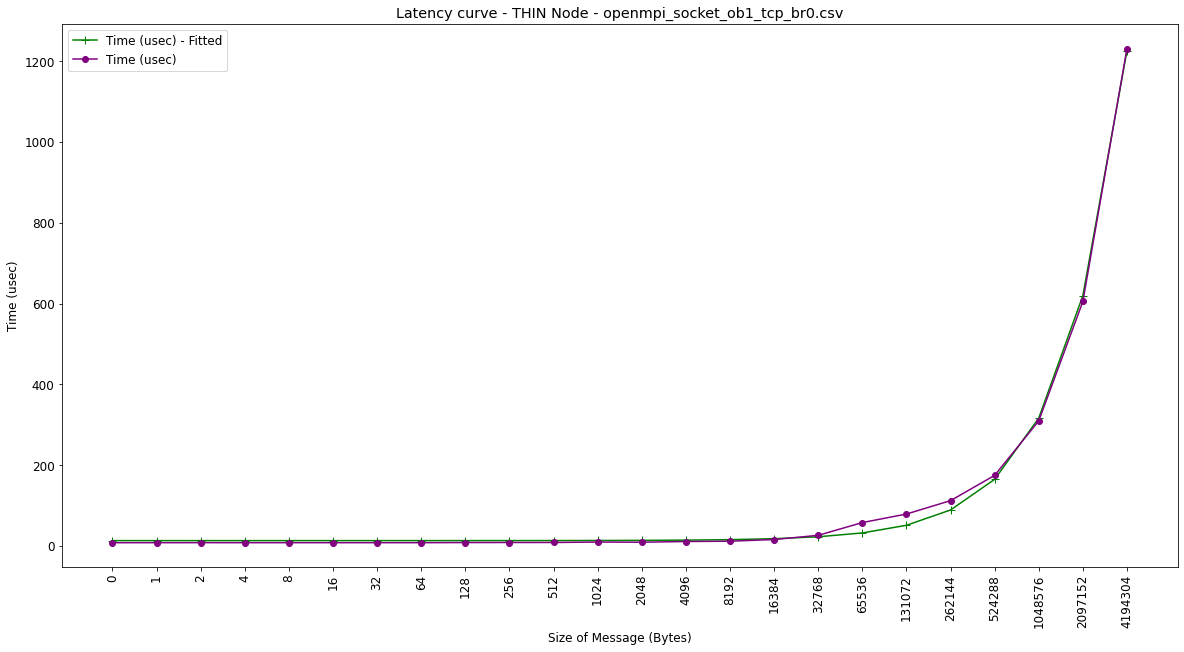

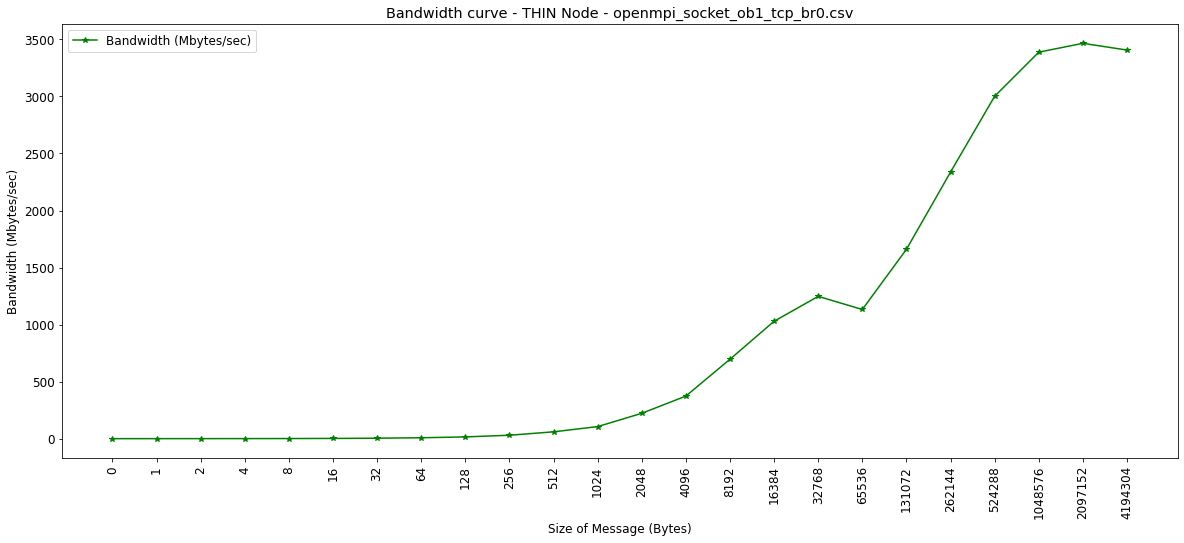

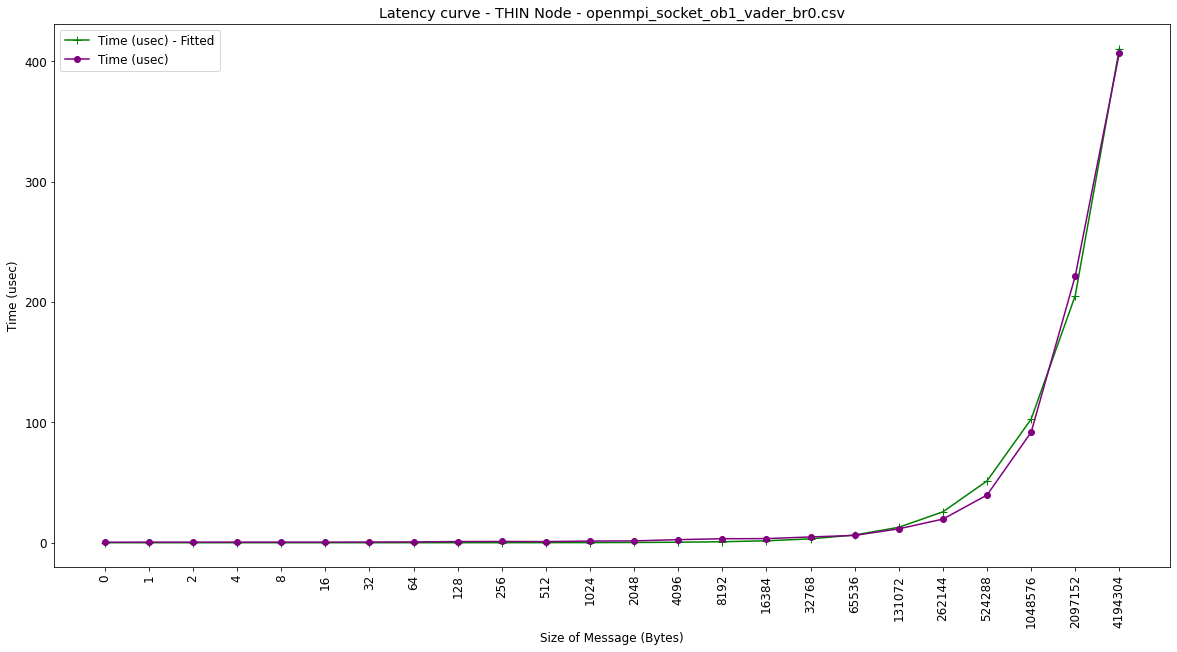

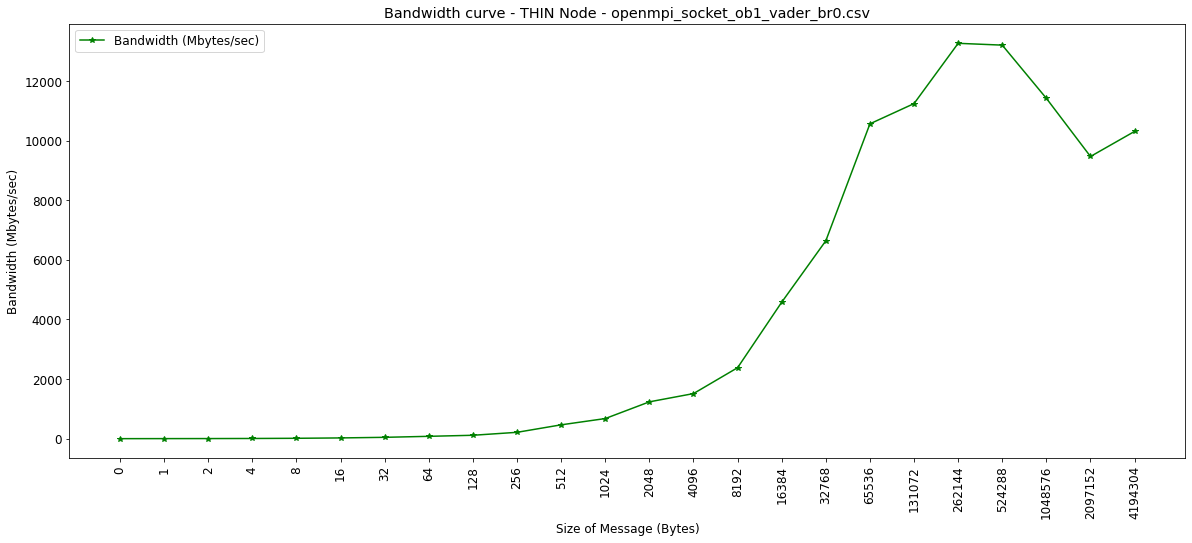

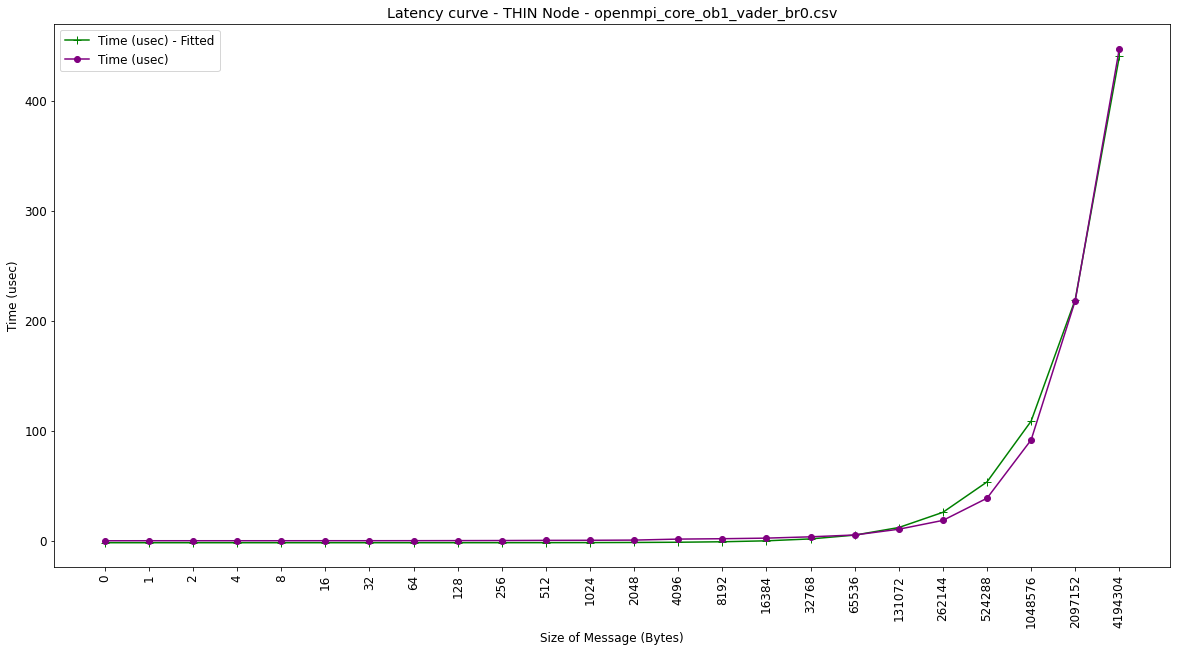

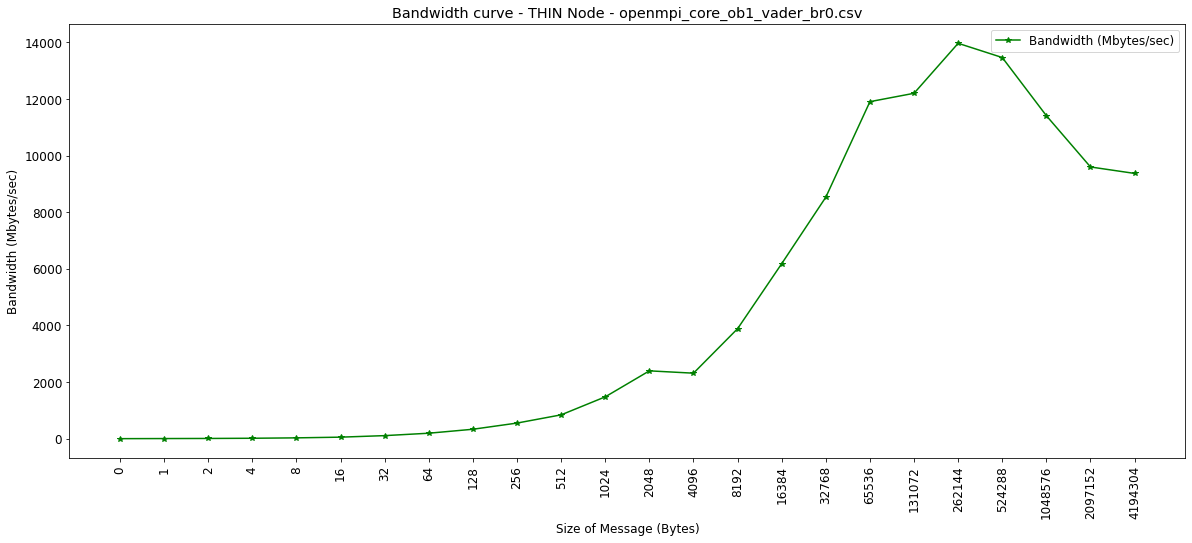

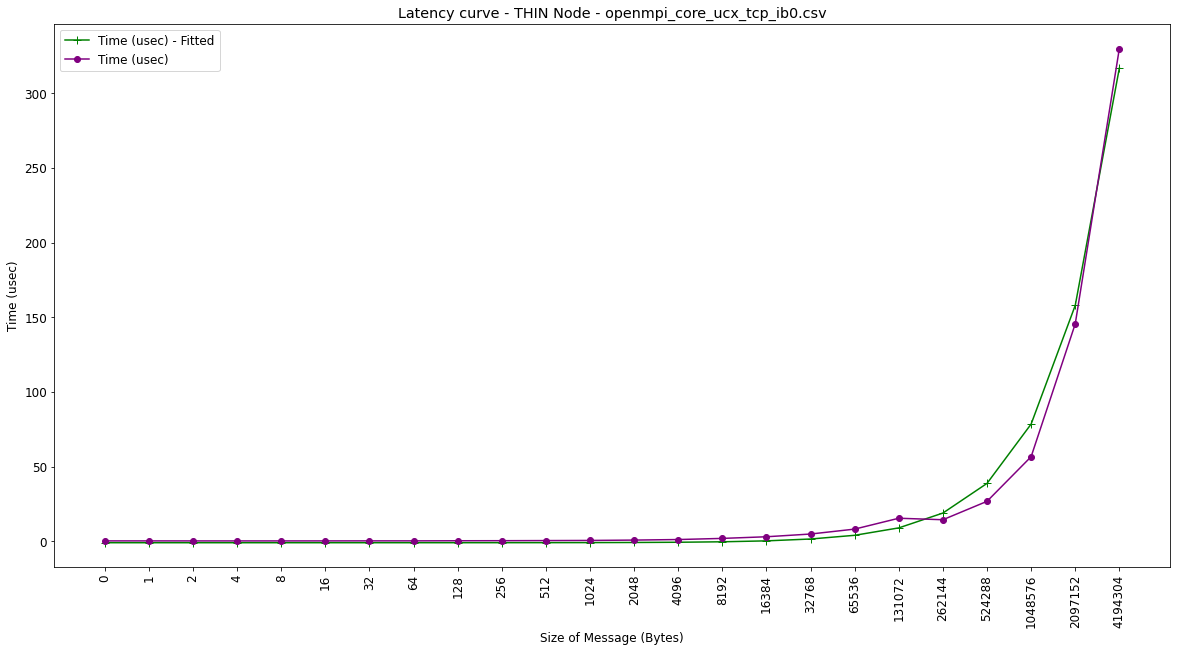

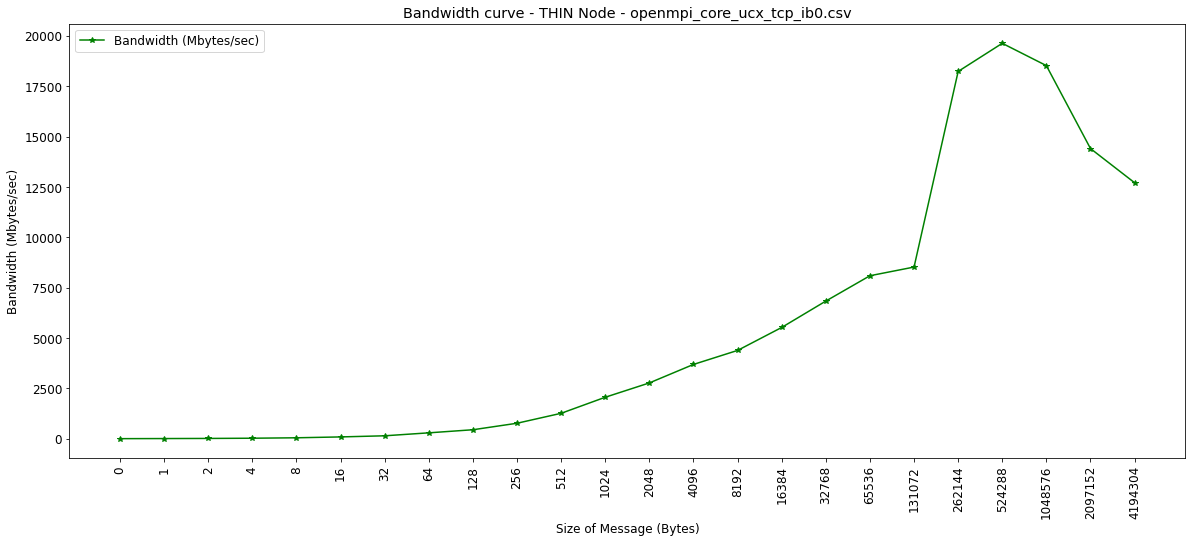

In [3]:
for file in files:
    df=pd.read_csv(file,header=3,index_col=False)
    
    #df["t[usec]"].mean()
    # store the values of relevant columns
    msgsize=df["#bytes"].values
    time=df["t[usec]"].values
    bandwidth=df["Mbytes/sec"].values
    
    # Linear regression using scipy.optimize
    def linear(x, m, c):
        return (m*x) + c 
    popt, pcov = curve_fit(linear, msgsize, time)
    latency_estimated_sp = popt[1]
    bandwidth_estimated_sp = 1/popt[0]
    
    # Linear Regression using sklearn
    msgsize_rearranged = msgsize.reshape(-1, 1)
    model = LinearRegression(positive=True).fit(msgsize_rearranged, time)
    
    # latency from fitted curve
    latency_fitted = model.intercept_ 
    
    # bandwith from fitted curve
    slope_fitted =  model.coef_
    bandwidth_fitted = 1/slope_fitted 
    
    # new values of time as per fit, for same values of 'x-axis ==> msgsize'
    time_estimated = model.predict(msgsize_rearranged)
    
    # other calculation of latency from first few points of data
    latency_estimated = np.mean(time[0:5])
    
    # other calculation of bandwidth from estimated time
    bandwidth_estimated = msgsize/(time_estimated)
    
    # original bandwidth, bandwidth estimated from time-curve, 
    # estimated from 1/slope in scipy fitting, estimated from 1/slope in linear fitting
    #print(bandwidth, bandwidth_estimated, bandwidth_estimated_sp, bandwidth_fitted)
    
    # latency from assuming first few small messages are basically all latency, 
    # latency from scipy linear fit, latency from sklearn linear fit
    #print(latency_estimated, latency_estimated_sp, latency_fitted)
    
    # time for first message originally, time for first message in fitted curve
    #print(time[0], time_estimated[0])
    
    # verification that linear fit works - tdiff should be [0,0,0...,0]
    #time_estimated_2 = latency_fitted + ((slope_fitted)*msgsize)
    #tdiff = np.abs(time_estimated_2 - time_estimated)    
    #print(tdiff)   
    
    #plot latency curve
    plt.figure(figsize=(20,10))
    plt.rc('font', size=12)
    plt.xlabel("Size of Message (Bytes)")
    plt.ylabel("Time (usec)")
    plt.title("Latency curve - THIN Node - "+file)
    plt.plot(msgsize.astype(str),time_estimated, label = "Time (usec) - Fitted", marker="+", markersize=8, color='green')
    plt.plot(msgsize.astype(str), time, label = "Time (usec)", marker="o", markersize=6, color='purple')
    plt.xticks(rotation=90)
    #plt.xscale("log")
    plt.legend()
    #plt.show()
    plt.savefig(file + "-latency.jpg")
    
    #plot bandwidth curve
    plt.figure(figsize=(20,8))
    plt.rc('font', size=12)
    plt.xlabel("Size of Message (Bytes)")
    plt.ylabel("Bandwidth (Mbytes/sec)")
    plt.title("Bandwidth curve - THIN Node - "+file)
    plt.plot(msgsize.astype(str), bandwidth, label = "Bandwidth (Mbytes/sec)", marker="*", markersize=6, color='g')
    plt.xticks(rotation=90)
    plt.legend()
    #plt.show()
    plt.savefig(file + "-bandwidth.jpg")
    
    # open original file to write correct latency and bandwidth
    with open(file, 'r') as f:
        data = f.readlines()
    
    # modify the relevant line to contain correct latency and bandwidth
    data[2] = "# Calculated Latency = "+np.around(np.abs(latency_estimated),3).astype(str)+" usec; Calculated Bandwidth = "+np.around(np.abs(bandwidth_estimated_sp),3).astype(str)+" MBytes/sec \n"
    
    # write correct latency and bandwidth in it
    with open(file, 'w') as f:
        f.writelines(data)    
    
    # Add new dataframes for 2 new columns as asked in assignment from their corresponding ndarrays
    df2 = pd.DataFrame(np.around(np.abs(time_estimated), 3))
    df3 = pd.DataFrame(np.around(np.abs(bandwidth_estimated), 3))
    
    # Append these columns to the existing dataframe with relevant headers
    df["t[usec] computed"] = df2
    df["Mbytes/sec (computed)"] = df3
    
    # modify the original file to contain this new data
    df.to_csv(file, mode='w',header=3, index=False)
    
    # open the "new original" file again
    with open(file, 'r') as f:
        data2 = f.readlines()
    # data2 is a list as type(data2) shows, so I insert elements into it like a list below
    
    # insert old headers into this file
    data2.insert(0, data[0])
    data2.insert(1, data[1])
    data2.insert(2, data[2])
    
    # write the final data into this file
    with open(file, 'w') as f:
        f.writelines(data2)  